# Working with Order Book Data: NASDAQ ITCH

The primary source of market data is the order book, which is continuously updated in real-time throughout the day to reflect all trading activity. Exchanges typically offer this data as a real-time service and may provide some historical data for free.

The trading activity is reflected in numerous messages about trade orders sent by market participants. These messages typically conform to the electronic Financial Information eXchange (FIX) communications protocol for real-time exchange of securities transactions and market data or a native exchange protocol. 

## Background

### The FIX Protocol

Just like SWIFT is the message protocol for back-office (example, for trade-settlement) messaging, the [FIX protocol](https://www.fixtrading.org/standards/) is the de facto messaging standard for communication before and during, trade execution between exchanges, banks, brokers, clearing firms, and other market participants. Fidelity Investments and Salomon Brothers introduced FIX in 1992 to facilitate electronic communication between broker-dealers and institutional clients who by then exchanged information over the phone.

It became popular in global equity markets before expanding into foreign exchange, fixed income and derivatives markets, and further into post-trade to support straight-through processing. Exchanges provide access to FIX messages as a real-time data feed that is parsed by algorithmic traders to track market activity and, for example, identify the footprint of market participants and anticipate their next move. 

### Nasdaq TotalView-ITCH Order Book data

While FIX has a dominant large market share, exchanges also offer native protocols. The Nasdaq offers a [TotalView ITCH direct data-feed protocol](http://www.nasdaqtrader.com/content/technicalsupport/specifications/dataproducts/NQTVITCHspecification.pdf) that allows subscribers to track 
individual orders for equity instruments from placement to execution or cancellation.

As a result, it allows for the reconstruction of the order book that keeps track of the list of active-limit buy and sell orders for a specific security or financial instrument. The order book reveals the market depth throughout the day by listing the number of shares being bid or offered at each price point. It may also identify the market participant responsible for specific buy and sell orders unless it is placed anonymously. Market depth is a key indicator of liquidity and the potential price impact of sizable market orders. 

The ITCH v5.0 specification declares over 20 message types related to system events, stock characteristics, the placement and modification of limit orders, and trade execution. It also contains information about the net order imbalance before the open and closing cross.

## Imports

In [1]:
import gzip
import shutil
from pathlib import Path
from urllib.request import urlretrieve
from urllib.parse import urljoin
from clint.textui import progress
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from struct import unpack
from collections import namedtuple, Counter
from datetime import timedelta
from time import time

## Get NASDAQ ITCH Data from FTP Server

The Nasdaq offers [samples](ftp://emi.nasdaq.com/ITCH/) of daily binary files for several months. 

We are now going to illustrates how to parse a sample file of ITCH messages and reconstruct both the executed trades and the order book for any given tick.

The data is fairly large and running the entire example can take a lot of time and require substantial memory (16GB+). Also, the sample file used in this example may no longer be available because NASDAQ occasionaly updates the sample files.

The following table shows the frequency of the most common message types for the sample file date March 29, 2018:

| Name                    | Offset  | Length  | Value      | Notes                                                                                |
|-------------------------|---------|---------|------------|--------------------------------------------------------------------------------------|
| Message Type            | 0       | 1       | S          | System Event Message                                                                 |
| Stock Locate            | 1       | 2       | Integer    | Always 0                                                                             |
| Tracking Number         | 3       | 2       | Integer    | Nasdaq internal tracking number                                                      |
| Timestamp               | 5       | 6       | Integer    | Nanoseconds since midnight                                                           |
| Order Reference Number  | 11      | 8       | Integer    | The unique reference number assigned to the new order at the time of receipt.        |
| Buy/Sell Indicator      | 19      | 1       | Alpha      | The type of order being added. B = Buy Order. S = Sell Order.                        |
| Shares                  | 20      | 4       | Integer    | The total number of shares associated with the order being added to the book.        |
| Stock                   | 24      | 8       | Alpha      | Stock symbol, right padded with spaces                                               |
| Price                   | 32      | 4       | Price (4)  | The display price of the new order. Refer to Data Types for field processing notes.  |
| Attribution             | 36      | 4       | Alpha      | Nasdaq Market participant identifier associated with the entered order               |

### Set Data paths

We will store the download in a `data` subdirectory and convert the result to `hdf` format (discussed in the last section of chapter 2).

In [80]:
data_path = Path('data') # set to e.g. external harddrive
itch_store = str(data_path / 'itch.h5')
order_book_store = data_path / 'order_book.h5'

The FTP address, filename and corresponding date used in this example:

This is already updated from the 2018 example used in the book:

In [22]:
FTP_URL = 'ftp://emi.nasdaq.com/ITCH/Nasdaq_ITCH/'
SOURCE_FILE = '03272019.NASDAQ_ITCH50.gz'

### Download & unzip

In [25]:
def may_be_download(url):
    """Download & unzip ITCH data if not yet available"""
    filename = data_path / url.split('/')[-1]
    if not data_path.exists():
        print('Creating directory')
        data_path.mkdir()
    if not filename.exists():
        print('Downloading...', url)
        urlretrieve(url, filename)
    unzipped = data_path / (filename.stem + '.bin')
    if not (data_path / unzipped).exists():
        print('Unzipping to', unzipped)
        with gzip.open(str(filename), 'rb') as f_in:
            with open(unzipped, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
    return unzipped

This will download 5.1GB data that unzips to 12.9GB.

In [26]:
file_name = may_be_download(urljoin(FTP_URL, SOURCE_FILE))
date = file_name.name.split('.')[0]

Downloading... ftp://emi.nasdaq.com/ITCH/Nasdaq_ITCH/03272019.NASDAQ_ITCH50.gz
Unzipping


## ITCH Format Settings

### The `struct` module for binary data

The ITCH tick data comes in binary format. Python provides the `struct` module (see [docs])(https://docs.python.org/3/library/struct.html) to parse binary data using format strings that identify the message elements by indicating length and type of the various components of the byte string as laid out in the specification.

From the docs:

> This module performs conversions between Python values and C structs represented as Python bytes objects. This can be used in handling binary data stored in files or from network connections, among other sources. It uses Format Strings as compact descriptions of the layout of the C structs and the intended conversion to/from Python values.

Let's walk through the critical steps to parse the trading messages and reconstruct the order book:

### Defining format strings

The parser uses format strings according to the following formats dictionaries:

In [58]:
event_codes = {'O': 'Start of Messages',
               'S': 'Start of System Hours',
               'Q': 'Start of Market Hours',
               'M': 'End of Market Hours',
               'E': 'End of System Hours',
               'C': 'End of Messages'}

In [59]:
encoding = {'primary_market_maker': {'Y': 1, 'N': 0},
            'printable'           : {'Y': 1, 'N': 0},
            'buy_sell_indicator'  : {'B': 1, 'S': -1},
            'cross_type'          : {'O': 0, 'C': 1, 'H': 2},
            'imbalance_direction' : {'B': 0, 'S': 1, 'N': 0, 'O': -1}}

In [60]:
formats = {
    ('integer', 2): 'H',
    ('integer', 4): 'I',
    ('integer', 6): '6s',
    ('integer', 8): 'Q',
    ('alpha', 1)  : 's',
    ('alpha', 2)  : '2s',
    ('alpha', 4)  : '4s',
    ('alpha', 8)  : '8s',
    ('price_4', 4): 'I',
    ('price_8', 8): 'Q',
}

### Create message specs for binary data parser

The ITCH parser relies on message specifications that we create in the following steps.

#### Load Message Types

The file `message_types.xlxs` contains the message type specs as laid out in the [documentation](https://www.nasdaqtrader.com/content/technicalsupport/specifications/dataproducts/NQTVITCHSpecification.pdf)

In [61]:
message_data = (pd.read_excel('message_types.xlsx',
                              sheet_name='messages',
                              encoding='latin1')
                .sort_values('id')
                .drop('id', axis=1))

#### Basic Cleaning

The function `clean_message_types()` just runs a few basic string cleaning steps.

In [62]:
def clean_message_types(df):
    df.columns = [c.lower().strip() for c in df.columns]
    df.value = df.value.str.strip()
    df.name = (df.name
               .str.strip() # remove whitespace
               .str.lower()
               .str.replace(' ', '_')
               .str.replace('-', '_')
               .str.replace('/', '_'))
    df.notes = df.notes.str.strip()
    df['message_type'] = df.loc[df.name == 'message_type', 'value']
    return df

In [63]:
message_types = clean_message_types(message_data)

#### Get Message Labels

We extract message type codes and names so we can later make the results more readable.

In [64]:
message_labels = (message_types.loc[:, ['message_type', 'notes']]
                  .dropna()
                  .rename(columns={'notes': 'name'}))
message_labels.name = (message_labels.name
                       .str.lower()
                       .str.replace('message', '')
                       .str.replace('.', '')
                       .str.strip().str.replace(' ', '_'))
# message_labels.to_csv('message_labels.csv', index=False)
message_labels.head()

,message_type,name
0,S,system_event
5,R,stock_directory
23,H,stock_trading_action
31,Y,reg_sho_short_sale_price_test_restricted_indic...
37,L,market_participant_position


### Finalize specification details

Each message consists of several fields that are defined by offset, length and type of value. The `struct` module will use this format information to parse the binary source data.

In [65]:
message_types.message_type = message_types.message_type.ffill()
message_types = message_types[message_types.name != 'message_type']
message_types.value = (message_types.value
                       .str.lower()
                       .str.replace(' ', '_')
                       .str.replace('(', '')
                       .str.replace(')', ''))
message_types.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 152 entries, 1 to 172
Data columns (total 6 columns):
name            152 non-null object
offset          152 non-null int64
length          152 non-null int64
value           152 non-null object
notes           152 non-null object
message_type    152 non-null object
dtypes: int64(2), object(4)
memory usage: 8.3+ KB


/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [68]:
message_types.head()

,name,offset,length,value,notes,message_type
0,stock_locate,1,2,integer,Always 0,S
1,tracking_number,3,2,integer,Nasdaq internal tracking number,S
2,timestamp,5,6,integer,Nanoseconds since midnight,S
3,event_code,11,1,alpha,See System Event Codes below,S
4,stock_locate,1,2,integer,Locate Code uniquely assigned to the security ...,R


Optionally, persist/reload from file:

In [67]:
message_types.to_csv('message_types.csv', index=False)
message_types = pd.read_csv('message_types.csv')

The parser translates the message specs into format strings and namedtuples that capture the message content. First, we create `(type, length)` formatting tuples from ITCH specs:

In [72]:
message_types.loc[:, 'formats'] = (message_types[['value', 'length']]
                            .apply(tuple, axis=1).map(formats))

Then, we extract formatting details for alphanumerical fields

In [73]:
alpha_fields = message_types[message_types.value == 'alpha'].set_index('name')
alpha_msgs = alpha_fields.groupby('message_type')
alpha_formats = {k: v.to_dict() for k, v in alpha_msgs.formats}
alpha_length = {k: v.add(5).to_dict() for k, v in alpha_msgs.length}

We generate message classes as named tuples and format strings

In [74]:
message_fields, fstring = {}, {}
for t, message in message_types.groupby('message_type'):
    message_fields[t] = namedtuple(typename=t, field_names=message.name.tolist())
    fstring[t] = '>' + ''.join(message.formats.tolist())

Fields of `alpha` type (alphanumeric) require post-processing as defined in the `format_alpha` function:

In [75]:
def format_alpha(mtype, data):
    """Process byte strings of type alpha"""

    for col in alpha_formats.get(mtype).keys():
        if mtype != 'R' and col == 'stock':
            data = data.drop(col, axis=1)
            continue
        data.loc[:, col] = data.loc[:, col].str.decode("utf-8").str.strip()
        if encoding.get(col):
            data.loc[:, col] = data.loc[:, col].map(encoding.get(col))
    return data

## Process Binary Message Data

The binary file for a single day contains over 350,000,000 messages worth over 12 GB.

In [76]:
def store_messages(m):
    """Handle occasional storing of all messages"""
    with pd.HDFStore(itch_store) as store:
        for mtype, data in m.items():
            # convert to DataFrame
            data = pd.DataFrame(data)

            # parse timestamp info
            data.timestamp = data.timestamp.apply(int.from_bytes, byteorder='big')
            data.timestamp = pd.to_timedelta(data.timestamp)

            # apply alpha formatting
            if mtype in alpha_formats.keys():
                data = format_alpha(mtype, data)

            s = alpha_length.get(mtype)
            if s:
                s = {c: s.get(c) for c in data.columns}
            dc = ['stock_locate']
            if m == 'R':
                dc.append('stock')
            store.append(mtype,
                         data,
                         format='t',
                         min_itemsize=s,
                         data_columns=dc)

In [77]:
messages = {}
message_count = 0
message_type_counter = Counter()

The script appends the parsed result iteratively to a file in the fast HDF5 format using the `store_messages()` function we just defined to avoid memory constraints (see last section in chapter 2 for more on this format).

The following (simplified) code processes the binary file and produces the parsed orders stored by message type:

In [78]:
start = time()
with file_name.open('rb') as data:
    while True:
        
        # determine message size in bytes
        message_size = int.from_bytes(data.read(2), byteorder='big', signed=False)
        
        # get message type by reading first byte
        message_type = data.read(1).decode('ascii')
        
        # create data structure to capture result
        if not messages.get(message_type):
            messages[message_type] = []

        message_type_counter.update([message_type])

        # read & store message
        record = data.read(message_size - 1)
        message = message_fields[message_type]._make(unpack(fstring[message_type], record))
        messages[message_type].append(message)
        
        # deal with system events
        if message_type == 'S':
            timestamp = int.from_bytes(message.timestamp, byteorder='big')
            print('\n', event_codes.get(message.event_code.decode('ascii'), 'Error'))
            print('\t{0}\t{1:,.0f}'.format(timedelta(seconds=timestamp * 1e-9),
                                         message_count))
            if message.event_code.decode('ascii') == 'C':
                store_messages(messages)
                break

        message_count += 1
        if message_count % 2.5e7 == 0:
            timestamp = int.from_bytes(message.timestamp, byteorder='big')
            print('\t{0}\t{1:,.0f}\t{2}'.format(timedelta(seconds=timestamp * 1e-9),
                                                message_count,
                                                timedelta(seconds=time() - start)))
            store_messages(messages)
            messages = {}
            
        
print(timedelta(seconds=time() - start))


 Start of Messages
	3:02:31.068526	0

 Start of System Hours
	4:00:00.000178	219,327

 Start of Market Hours
	9:30:00.000043	11,818,063
	9:39:31.144741	25,000,000	0:01:08.467859
	9:57:14.988340	50,000,000	0:03:45.147662
	10:18:35.622104	75,000,000	0:06:09.602826
	10:41:29.750289	100,000,000	0:08:41.255368
	11:00:23.926562	125,000,000	0:11:07.380716
	11:21:45.482872	150,000,000	0:13:38.170886
	11:41:28.563142	175,000,000	0:16:06.822987
	12:01:10.424691	200,000,000	0:18:35.938550
	12:23:19.747779	225,000,000	0:21:05.921591
	12:49:58.364558	250,000,000	0:23:36.679611
	13:18:58.142268	275,000,000	0:26:03.764827
	13:50:59.091083	300,000,000	0:28:31.018804
	14:24:40.536031	325,000,000	0:31:00.906482
	14:55:33.944883	350,000,000	0:33:30.878899
	15:25:11.750566	375,000,000	0:36:00.636504
	15:50:06.330012	400,000,000	0:38:27.319121

 End of Market Hours
	16:00:00.000043	419,555,641

 End of System Hours
	20:00:00.000023	422,232,228

 End of Messages
	20:05:00.000034	422,264,304
0:42:00.168006


## Summarize Trading Day

### Trading Message Frequency

In [79]:
counter = pd.Series(message_type_counter).to_frame('# Trades')
counter['Message Type'] = counter.index.map(message_labels.set_index('message_type').name.to_dict())
counter = counter[['Message Type', '# Trades']].sort_values('# Trades', ascending=False)
print(counter)

                                        Message Type   # Trades
A                      add_order_no_mpid_attribution  186296811
D                                       order_delete  181953144
U                                      order_replace   34555656
E                                     order_executed    7331047
X                                       order_cancel    5495709
I                                               noii    3674503
F                         add_order_mpid_attribution    1477447
P                                              trade    1105314
L                        market_participant_position     193290
C                          order_executed_with_price     137556
Q                                        cross_trade      17445
Y  reg_sho_short_sale_price_test_restricted_indic...       8853
H                               stock_trading_action       8780
R                                    stock_directory       8712
J                                luld_au

In [81]:
with pd.HDFStore(itch_store) as store:
    store.put('summary', counter)

### Top Equities by Traded Value

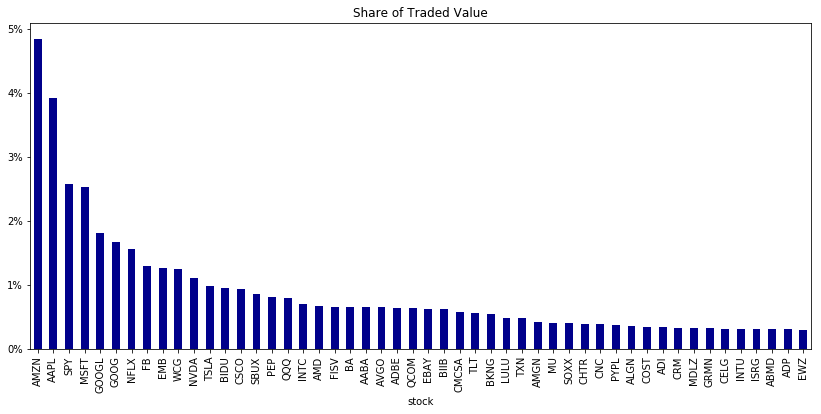

In [82]:
with pd.HDFStore(itch_store) as store:
    stocks = store['R'].loc[:, ['stock_locate', 'stock']]
    trades = store['P'].append(store['Q'].rename(columns={'cross_price': 'price'}), sort=False).merge(stocks)
trades['value'] = trades.shares.mul(trades.price)
trades['value_share'] = trades.value.div(trades.value.sum())
trade_summary = trades.groupby('stock').value_share.sum().sort_values(ascending=False)
trade_summary.iloc[:50].plot.bar(figsize=(14, 6), color='darkblue', title='Share of Traded Value')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

## Build Order Book

In [83]:
stock = 'AAPL'
order_dict = {-1: 'sell', 1: 'buy'}

The parsed messages allow us to rebuild the order flow for the given day. The 'R' message type contains a listing of all stocks traded during a given day, including information about initial public offerings (IPOs) and trading restrictions.

Throughout the day, new orders are added, and orders that are executed and canceled are removed from the order book. The proper accounting for messages that reference orders placed on a prior date would require tracking the order book over multiple days, but we are ignoring this aspect here.

### Get all messages for given stock

The `get_messages()` function illustrates how to collect the orders for a single stock that affects trading (refer to the ITCH specification for details about each message):

In [84]:
def get_messages(date, stock=stock):
    """Collect trading messages for given stock"""
    with pd.HDFStore(itch_store) as store:
        stock_locate = store.select('R', where='stock = stock').stock_locate.iloc[0]
        target = 'stock_locate = stock_locate'

        data = {}
        # trading message types
        messages = ['A', 'F', 'E', 'C', 'X', 'D', 'U', 'P', 'Q']
        for m in messages:
            data[m] = store.select(m, where=target).drop('stock_locate', axis=1).assign(type=m)

    order_cols = ['order_reference_number', 'buy_sell_indicator', 'shares', 'price']
    orders = pd.concat([data['A'], data['F']], sort=False, ignore_index=True).loc[:, order_cols]

    for m in messages[2: -3]:
        data[m] = data[m].merge(orders, how='left')

    data['U'] = data['U'].merge(orders, how='left',
                                right_on='order_reference_number',
                                left_on='original_order_reference_number',
                                suffixes=['', '_replaced'])

    data['Q'].rename(columns={'cross_price': 'price'}, inplace=True)
    data['X']['shares'] = data['X']['cancelled_shares']
    data['X'] = data['X'].dropna(subset=['price'])

    data = pd.concat([data[m] for m in messages], ignore_index=True, sort=False)
    data['date'] = pd.to_datetime(date, format='%m%d%Y')
    data.timestamp = data['date'].add(data.timestamp)
    data = data[data.printable != 0]

    drop_cols = ['tracking_number', 'order_reference_number', 'original_order_reference_number',
                 'cross_type', 'new_order_reference_number', 'attribution', 'match_number',
                 'printable', 'date', 'cancelled_shares']
    return data.drop(drop_cols, axis=1).sort_values('timestamp').reset_index(drop=True)


In [85]:
messages = get_messages(date=date)
messages.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2010099 entries, 0 to 2010098
Data columns (total 9 columns):
timestamp             2010099 non-null datetime64[ns]
buy_sell_indicator    1873082 non-null float64
shares                1995581 non-null float64
price                 1995581 non-null float64
type                  2010099 non-null object
executed_shares       54956 non-null float64
execution_price       500 non-null float64
shares_replaced       14159 non-null float64
price_replaced        14159 non-null float64
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 138.0+ MB


In [86]:
with pd.HDFStore(order_book_store) as store:
    key = '{}/messages'.format(stock)
    store.put(key, messages)
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: data/order_book.h5
/AAPL/messages            frame        (shape->[2010099,9])


### Combine Trading Records

Reconstructing successful trades, that is, orders that are executed as opposed to those that were canceled from trade-related message types, C, E, P, and Q, is relatively straightforward:

In [87]:
def get_trades(m):
    """Combine C, E, P and Q messages into trading records"""
    trade_dict = {'executed_shares': 'shares', 'execution_price': 'price'}
    cols = ['timestamp', 'executed_shares']
    trades = pd.concat([m.loc[m.type == 'E', cols + ['price']].rename(columns=trade_dict),
                        m.loc[m.type == 'C', cols + ['execution_price']].rename(columns=trade_dict),
                        m.loc[m.type == 'P', ['timestamp', 'price', 'shares']],
                        m.loc[m.type == 'Q', ['timestamp', 'price', 'shares']].assign(cross=1),
                        ], sort=False).dropna(subset=['price']).fillna(0)
    return trades.set_index('timestamp').sort_index().astype(int)

In [88]:
trades = get_trades(messages)
print(trades.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 59796 entries, 2019-03-27 04:00:56.459428646 to 2019-03-27 19:54:05.600648466
Data columns (total 3 columns):
shares    59796 non-null int64
price     59796 non-null int64
cross     59796 non-null int64
dtypes: int64(3)
memory usage: 1.8 MB
None


In [89]:
with pd.HDFStore(order_book_store) as store:
    store.put('{}/trades'.format(stock), trades)

### Create Orders

The order book keeps track of limit orders, and the various price levels for buy and sell orders constitute the depth of the order book. To reconstruct the order book for a given level of depth requires the following steps:


The `add_orders()` function accumulates sell orders in ascending, and buy orders in descending order for a given timestamp up to the desired level of depth:

In [90]:
def add_orders(orders, buysell, nlevels):
    """Add orders up to desired depth given by nlevels;
        sell in ascending, buy in descending order
    """
    new_order = []
    items = sorted(orders.copy().items())
    if buysell == 1:
        items = reversed(items)  
    for i, (p, s) in enumerate(items, 1):
        new_order.append((p, s))
        if i == nlevels:
            break
    return orders, new_order

In [91]:
def save_orders(orders, append=False):
    cols = ['price', 'shares']
    for buysell, book in orders.items():
        df = (pd.concat([pd.DataFrame(data=data,
                                     columns=cols)
                         .assign(timestamp=t) 
                         for t, data in book.items()]))
        key = '{}/{}'.format(stock, order_dict[buysell])
        df.loc[:, ['price', 'shares']] = df.loc[:, ['price', 'shares']].astype(int)
        with pd.HDFStore(order_book_store) as store:
            if append:
                store.append(key, df.set_index('timestamp'), format='t')
            else:
                store.put(key, df.set_index('timestamp'))

We iterate over all ITCH messages and process orders and their replacements as required by the specification (this can take a while):

In [92]:
order_book = {-1: {}, 1: {}}
current_orders = {-1: Counter(), 1: Counter()}
message_counter = Counter()
nlevels = 100

start = time()
for message in messages.itertuples():
    i = message[0]
    if i % 1e5 == 0 and i > 0:
        print('{:,.0f}\t\t{}'.format(i, timedelta(seconds=time() - start)))
        save_orders(order_book, append=True)
        order_book = {-1: {}, 1: {}}
        start = time()
    if np.isnan(message.buy_sell_indicator):
        continue
    message_counter.update(message.type)

    buysell = message.buy_sell_indicator
    price, shares = None, None

    if message.type in ['A', 'F', 'U']:
        price = int(message.price)
        shares = int(message.shares)

        current_orders[buysell].update({price: shares})
        current_orders[buysell], new_order = add_orders(current_orders[buysell], buysell, nlevels)
        order_book[buysell][message.timestamp] = new_order

    if message.type in ['E', 'C', 'X', 'D', 'U']:
        if message.type == 'U':
            if not np.isnan(message.shares_replaced):
                price = int(message.price_replaced)
                shares = -int(message.shares_replaced)
        else:
            if not np.isnan(message.price):
                price = int(message.price)
                shares = -int(message.shares)

        if price is not None:
            current_orders[buysell].update({price: shares})
            if current_orders[buysell][price] <= 0:
                current_orders[buysell].pop(price)
            current_orders[buysell], new_order = add_orders(current_orders[buysell], buysell, nlevels)
            order_book[buysell][message.timestamp] = new_order

100,000		0:00:35.307123
200,000		0:00:40.583205
300,000		0:00:41.415511
400,000		0:00:39.333220
500,000		0:00:41.455615
600,000		0:00:40.160583
700,000		0:00:41.100331
800,000		0:00:42.812086
900,000		0:00:43.454985
1,000,000		0:00:44.803726
1,100,000		0:00:44.562056
1,200,000		0:00:44.481447
1,300,000		0:00:45.515291
1,400,000		0:00:45.255271
1,500,000		0:00:46.097667
1,600,000		0:00:45.258312
1,700,000		0:00:45.652722
1,800,000		0:00:47.688795
1,900,000		0:00:49.200748
2,000,000		0:00:48.342637


In [93]:
message_counter = pd.Series(message_counter)
print(message_counter)

A    924117
D    869968
X      2789
E     52299
P      6995
F      2282
U     14159
C       473
dtype: int64


In [94]:
with pd.HDFStore(order_book_store) as store:
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: data/order_book.h5
/AAPL/buy                 frame_table  (typ->appendable,nrows->88554121,ncols->2,indexers->[index],dc->[])
/AAPL/messages            frame        (shape->[2010099,9])                                               
/AAPL/sell                frame_table  (typ->appendable,nrows->91632307,ncols->2,indexers->[index],dc->[])
/AAPL/trades              frame        (shape->[59796,3])                                                 


## Order Book Depth

In [95]:
with pd.HDFStore(order_book_store) as store:
    buy = store['{}/buy'.format(stock)].reset_index().drop_duplicates()
    sell = store['{}/sell'.format(stock)].reset_index().drop_duplicates()

### Price to Decimals

In [96]:
buy.price = buy.price.mul(1e-4)
sell.price = sell.price.mul(1e-4)

### Remove outliers

In [97]:
percentiles = [.01, .02, .1, .25, .75, .9, .98, .99]
pd.concat([buy.price.describe(percentiles=percentiles).to_frame('buy'),
           sell.price.describe(percentiles=percentiles).to_frame('sell')], axis=1)

,buy,sell
count,8.855412e+07,9.163231e+07
mean,1.889559e+02,1.927302e+02
std,2.192705e+00,9.469004e+02
min,1.000000e-04,1.865500e+02
1%,1.878300e+02,1.866300e+02
2%,1.880000e+02,1.867900e+02
10%,1.885200e+02,1.870800e+02
25%,1.887200e+02,1.873900e+02
50%,1.890300e+02,1.879600e+02
75%,1.893800e+02,1.888000e+02


In [98]:
buy = buy[buy.price > buy.price.quantile(.01)]
sell = sell[sell.price < sell.price.quantile(.99)]

### Buy-Sell Order Distribution

The number of orders at different price levels, highlighted in the following screenshot using different intensities for buy and sell orders, visualizes the depth of liquidity at any given point in time.

The distribution of limit order prices was weighted toward buy orders at higher prices.

In [99]:
market_open='0930'
market_close = '1600'

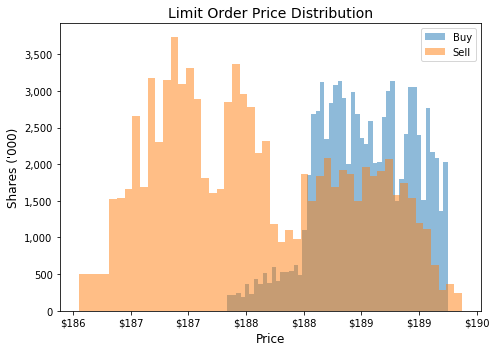

In [100]:
fig, ax = plt.subplots(figsize=(7,5))
hist_kws = {'linewidth': 1, 'alpha': .5}
sns.distplot(buy.set_index('timestamp').between_time(market_open, market_close).price, ax=ax, label='Buy', kde=False, hist_kws=hist_kws)
sns.distplot(sell.set_index('timestamp').between_time(market_open, market_close).price, ax=ax, label='Sell', kde=False, hist_kws=hist_kws)
plt.legend(fontsize=10)
plt.title('Limit Order Price Distribution', fontsize=14)
ax.set_yticklabels(['{:,}'.format(int(y/1000)) for y in ax.get_yticks().tolist()])
ax.set_xticklabels(['${:,}'.format(int(x)) for x in ax.get_xticks().tolist()])
plt.xlabel('Price', fontsize=12)
plt.ylabel('Shares (\'000)', fontsize=12)
plt.tight_layout()
# plt.savefig('figures/price_distribution', dpi=600);

### Order Book Depth

In [101]:
utc_offset = timedelta(hours=4)
depth = 100

In [102]:
buy_per_min = (buy
               .groupby([pd.Grouper(key='timestamp', freq='Min'), 'price'])
               .shares
               .sum()
               .apply(np.log)
               .to_frame('shares')
               .reset_index('price')
               .between_time(market_open, market_close)
               .groupby(level='timestamp', as_index=False, group_keys=False)
               .apply(lambda x: x.nlargest(columns='price', n=depth))
               .reset_index())
buy_per_min.timestamp = buy_per_min.timestamp.add(utc_offset).astype(int)
buy_per_min.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39093 entries, 0 to 39092
Data columns (total 3 columns):
timestamp    39093 non-null int64
price        39093 non-null float64
shares       39093 non-null float64
dtypes: float64(2), int64(1)
memory usage: 916.3 KB


In [103]:
sell_per_min = (sell
                .groupby([pd.Grouper(key='timestamp', freq='Min'), 'price'])
                .shares
                .sum()
                .apply(np.log)
                .to_frame('shares')
                .reset_index('price')
                .between_time(market_open, market_close)
                .groupby(level='timestamp', as_index=False, group_keys=False)
                .apply(lambda x: x.nsmallest(columns='price', n=depth))
                .reset_index())

sell_per_min.timestamp = sell_per_min.timestamp.add(utc_offset).astype(int)
sell_per_min.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39085 entries, 0 to 39084
Data columns (total 3 columns):
timestamp    39085 non-null int64
price        39085 non-null float64
shares       39085 non-null float64
dtypes: float64(2), int64(1)
memory usage: 916.1 KB


In [104]:
with pd.HDFStore(order_book_store) as store:
    trades = store['{}/trades'.format(stock)]
trades.price = trades.price.mul(1e-4)
trades = trades[trades.cross == 0].between_time(market_open, market_close)

trades_per_min = (trades
                  .resample('Min')
                  .agg({'price': 'mean', 'shares': 'sum'}))
trades_per_min.index = trades_per_min.index.to_series().add(utc_offset).astype(int)
trades_per_min.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 390 entries, 1553693400000000000 to 1553716740000000000
Data columns (total 2 columns):
price     390 non-null float64
shares    390 non-null int64
dtypes: float64(1), int64(1)
memory usage: 9.1 KB


The following plots the evolution of limit orders and prices throughout the trading day: the dark line tracks the prices for executed trades during market hours, whereas the red and blue dots indicate individual limit orders on a per-minute basis (see notebook for details)

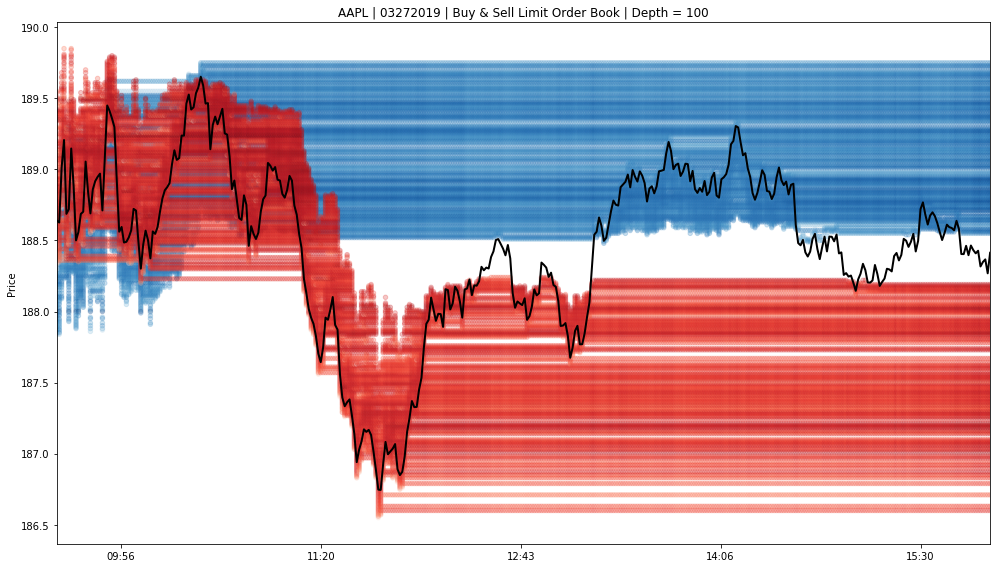

In [105]:
fig, ax = plt.subplots(figsize=(7, 5))

buy_per_min.plot.scatter(x='timestamp',y='price', c='shares', ax=ax, colormap='Blues', colorbar=False, alpha=.25)
sell_per_min.plot.scatter(x='timestamp',y='price', c='shares', ax=ax, colormap='Reds', colorbar=False, alpha=.25)
trades_per_min.price.plot(figsize=(14, 8), c='k', ax=ax, lw=2, 
                          title=f'AAPL | {date} | Buy & Sell Limit Order Book | Depth = {depth}')

xticks = [datetime.fromtimestamp(ts / 1e9).strftime('%H:%M') for ts in ax.get_xticks()]
ax.set_xticklabels(xticks)

ax.set_xlabel('')
ax.set_ylabel('Price')

fig.tight_layout()
# fig.savefig('figures/order_book', dpi=600);